In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sklearn as sk
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# import package to count number of hours after specific time
from datetime import datetime


ModuleNotFoundError: No module named 'sklearn'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
file_path = '/content/drive/My Drive/LondonDataDive2024/Data/AQ_CS_All_Full.csv'

In [10]:

# Faerier, adjusts for modulation, 7, 31
# Plot residuals to Faerier plot

# Define file paths
#combined_dataset = "/home/henry-cao/Desktop/KCL/Extracurriculars/CUSP/Project_Code/Datasets/no_na_dataset.csv"

# Load data
data = pd.read_csv(file_path)


In [11]:

# Print col names
print(data.columns)

# Print number of rows
print("Number of rows before preprocessing: ", data.shape[0])

# Only keep unique rows
data = data.drop_duplicates()

# Drop na values from Measurement, SatMean, and FlowMean
data = data.dropna(subset=['Measurement', 'SatMean', 'FlowMean'])

# When SatMean is less than 0, set value to na
data.loc[data['SatMean'] < 0, 'SatMean'] = np.nan

# Covert time column to datetime
data['time_temp'] = pd.to_datetime(data['MeasurementDateGMT'])

# Find earliest timestamp
earliest_timestamp = data['time_temp'].min()

# Calculated time elapsed
data['time_elapsed'] = data['time_temp'] - earliest_timestamp

# Turn time_elapsed into float32
data['time_elapsed'] = data['time_elapsed'].dt.total_seconds().astype('float32')

# Drop MeasurementDateGMT and time columns
data = data.drop(columns=['time_temp'])

# Convert certain categorical variables to numerical encoded values
data['SiteType'] = data['SiteType'].astype('category').cat.codes

# Store unique values of SpeciesType
unique_species_values = data['SpeciesType'].unique()

# Convert SpeciesType to numerical encoded values, and link up unique_species_values w/ numerical values
data['SpeciesType'] = data['SpeciesType'].astype('category').cat.codes
unique_species_dict = {i: unique_species_values[i] for i in range(len(unique_species_values))}

# Turn time, which represents exact hour of the day, into numerical
data['Hour'] = data['MeasurementDateGMT'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M').hour).astype(int)

# Extract day, month, and year from MeasurmentDateGMT
# Day is in index 0-1, month is in index 5-7, year is in index 9-12
# Time is in format YYYY-MM-DD HH:MM
data['Day'] = data['MeasurementDateGMT'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M').day).astype(int)
data['Month'] = data['MeasurementDateGMT'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M').month).astype(int)
data['Year'] = data['MeasurementDateGMT'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M').year).astype(int)

# Dropping irrelevant or redundant columns
data = data.drop(columns=['MeasurementDateGMT', 'LocalAuthorityName', 'SiteCode', 'LocalAuthorityCode', 'SiteName', 'DateOpened', 'DateClosed', 'ID', 'DateTime', 'date',  'Date', 'SatBand', 'DateTimeStr', 'Time'])

# Print number of rows
print("Number of rows after preprocessing: ", data.shape[0])


Index(['MeasurementDateGMT', 'Measurement', 'SiteCode', 'LocalAuthorityCode',
       'LocalAuthorityName', 'SiteName', 'SiteType', 'DateOpened',
       'DateClosed', 'Latitude', 'Longitude', 'SpeciesType', 'ID', 'DateTime',
       'Date', 'Time', 'SatMean', 'SatBand', 'FlowMean', 'DateTimeStr', 'date',
       'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'wind_speed_10m (km/h)', 'wind_direction_10m (°)'],
      dtype='object')
Number of rows before preprocessing:  389033
Number of rows after preprocessing:  389011


In [12]:

# Define input size annd output size based on data shape
num_features = data.shape[1] - 1

# Making sure dropped columns are gone
print(f"Columns remaining: {data.columns}")

# Make test and training sets, with Measurements as response variable and
# all other variables as predictors
X = data.drop(columns=['Measurement'])
y = data['Measurement']

# Converting datatypes to float32
X = X.astype('float32')
y = y.astype('float32')

# # Initialise MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0,1))
# X_scaled = scaler.fit_transform(X)



Columns remaining: Index(['Measurement', 'SiteType', 'Latitude', 'Longitude', 'SpeciesType',
       'SatMean', 'FlowMean', 'temperature_2m (°C)',
       'relative_humidity_2m (%)', 'wind_speed_10m (km/h)',
       'wind_direction_10m (°)', 'time_elapsed', 'Hour', 'Day', 'Month',
       'Year'],
      dtype='object')


Pollutant: NO2
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 500)               1030000   
                                                                 
 dense_4 (Dense)             (None, 1)                 501       
                                                                 
Total params: 1030501 (3.93 MB)
Trainable params: 1030501 (3.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
449/449 [==============================] - 4s 6ms/step - loss: 1466.0946 - val_loss: 629.7972
Epoch 2/300
 24/449 [>.............................] - ETA: 1s - loss: 653.9438

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


449/449 [==============================] - 2s 5ms/step - loss: 563.0843 - val_loss: 500.0066
Epoch 3/300
449/449 [==============================] - 3s 7ms/step - loss: 482.1276 - val_loss: 450.0981
Epoch 4/300
449/449 [==============================] - 3s 6ms/step - loss: 446.0782 - val_loss: 426.0599
Epoch 5/300
449/449 [==============================] - 2s 5ms/step - loss: 425.4437 - val_loss: 409.8160
Epoch 6/300
449/449 [==============================] - 2s 5ms/step - loss: 410.3892 - val_loss: 397.6211
Epoch 7/300
449/449 [==============================] - 2s 6ms/step - loss: 398.0058 - val_loss: 386.4141
Epoch 8/300
449/449 [==============================] - 3s 7ms/step - loss: 387.1467 - val_loss: 374.5682
Epoch 9/300
449/449 [==============================] - 3s 6ms/step - loss: 376.9414 - val_loss: 366.2293
Epoch 10/300
449/449 [==============================] - 2s 6ms/step - loss: 367.8964 - val_loss: 356.7796
Epoch 11/300
449/449 [==============================] - 2s 5ms/ste

1122/1122 [==============================] - 2s 2ms/step


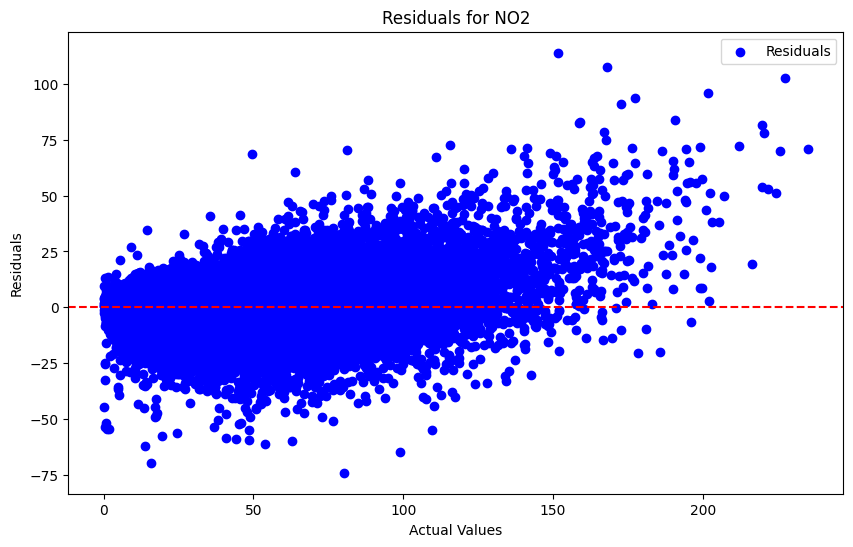

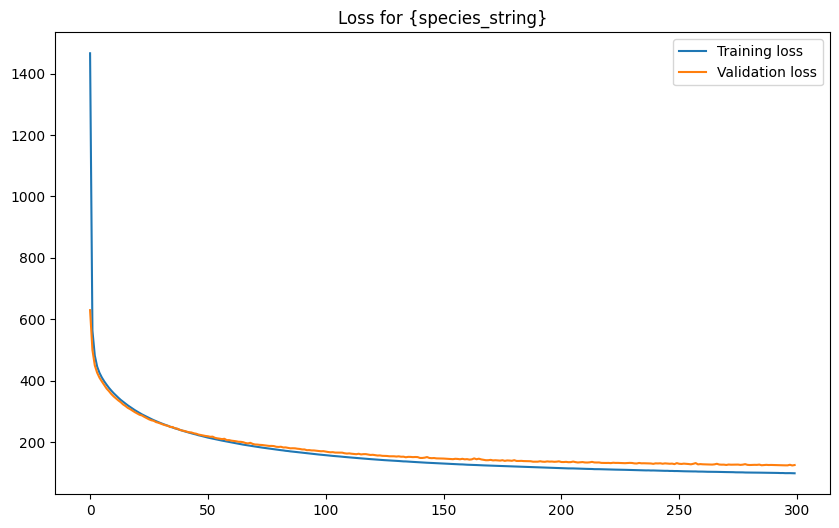

Mean squared error for {species}:  127.89512
Pollutant: PM10
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 500)               1030000   
                                                                 
 dense_5 (Dense)             (None, 1)                 501       
                                                                 
Total params: 1030501 (3.93 MB)
Trainable params: 1030501 (3.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
357/357 [==============================] - 5s 9ms/step - loss: 288.6920 - val_loss: 144.5696
Epoch 2/300
 20/357 [>.............................] - ETA: 1s - loss: 141.3180

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


357/357 [==============================] - 2s 6ms/step - loss: 151.5854 - val_loss: 124.6143
Epoch 3/300
357/357 [==============================] - 2s 6ms/step - loss: 135.9501 - val_loss: 114.6405
Epoch 4/300
357/357 [==============================] - 2s 6ms/step - loss: 128.2621 - val_loss: 108.2715
Epoch 5/300
357/357 [==============================] - 2s 6ms/step - loss: 122.2934 - val_loss: 103.2394
Epoch 6/300
357/357 [==============================] - 2s 7ms/step - loss: 117.1892 - val_loss: 98.6630
Epoch 7/300
357/357 [==============================] - 3s 8ms/step - loss: 113.0574 - val_loss: 94.6397
Epoch 8/300
357/357 [==============================] - 2s 6ms/step - loss: 109.6847 - val_loss: 91.8526
Epoch 9/300
357/357 [==============================] - 2s 6ms/step - loss: 106.6983 - val_loss: 89.5184
Epoch 10/300
357/357 [==============================] - 2s 6ms/step - loss: 104.3287 - val_loss: 86.9295
Epoch 11/300
357/357 [==============================] - 2s 6ms/step - l

In [ ]:
# Separate by SpeciesType
unique_species = data['SpeciesType'].unique()
for species in unique_species:
    # Use unique_species_dict to print species
    species_string = unique_species_dict[species]
    print(f"Pollutant: {species_string}")

    # Filter data by species
    data_species = data[data['SpeciesType'] == species]

    # Make test and training sets, with Measurements as response variable
    X_species = data_species.drop(columns=['Measurement', 'SpeciesType'])
    y_species = data_species['Measurement']
    X_species = X_species.astype('float32')
    y_species = y_species.astype('float32')

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_species)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_species, test_size=0.2, random_state=1)

    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    model = Sequential([
        LSTM(units=500, activation='relu', input_shape=(1, X_train.shape[2]), recurrent_initializer='glorot_uniform'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=0.5), loss='mean_squared_error')

    model.summary()

    checkpoint_filepath = f"'/content/drive/My Drive/LondonDataDive2024/Data/Models/checkpoint/checkpoint_{species_string}.h5"
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    # Fit model
    history = model.fit(X_train, y_train, epochs=300, batch_size=256, validation_split = 0.2, callbacks=[model_checkpoint_callback])

    # Load best model
    best_model = load_model(checkpoint_filepath)

    # Make predictions
    y_pred = model.predict(X_test)

    # Plot Residuals between real and predicted values
    y_residuals = y_test - y_pred.flatten()
    plt.figure(figsize=(10,6))
    plt.scatter(y_test, y_residuals, color='blue', label='Residuals')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals for {species_string}')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss for {species_string}')
    plt.legend()
    plt.show()

    # # Calculate and print accuracy of predictions
    MSE = sk.metrics.mean_squared_error(y_test, y_pred)
    print("Mean squared error for {species}: ", MSE)







In [ ]:

# # Initialise StandardScaler
# scaler = StandardScaler()

# # Fit X to have mean 0 and variance 1
# X_scaled = scaler.fit_transform(X)

# # Split data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

# X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# model = Sequential([
#     LSTM(units=500, activation='relu', input_shape=(1, X_train.shape[2]), recurrent_initializer='glorot_uniform'),
#     Dense(1)
# ])

# model.compile(optimizer=Adam(learning_rate=0.001, clipvalue=0.5), loss='mean_squared_error')

# model.summary()

# checkpoint_filepath = '/home/henry-cao/Desktop/KCL/Extracurriculars/CUSP/Project_Code/CUSP_source/LSTM_Models/checkpoint_model.h5'
# model_checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=False,
#     monitor='val_loss',
#     mode='min',
#     save_best_only=True
# )

# # Fit model
# history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split = 0.2, callbacks=[model_checkpoint_callback])

# # Load best model
# best_model = load_model(checkpoint_filepath)

# # Make predictions
# y_pred = model.predict(X_test)

# # Plot Residuals between real and predicted values
# y_residuals = y_test - y_pred.flatten()
# plt.figure(figsize=(10,6))
# plt.scatter(y_test, y_residuals, color='blue', label='Residuals')
# plt.axhline(y=0, color='red', linestyle='--')
# plt.xlabel('Actual Values')
# plt.ylabel('Residuals')
# plt.title('Residuals')
# plt.legend()
# plt.show()

# # Plot accuracy
# plt.figure(figsize=(10,6))
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.title('Loss')
# plt.legend()
# plt.show()

# # Calculate and print accuracy of predictions
MSE = sk.metrics.mean_squared_error(y_test, y_pred)
print("Mean squared error: ", MSE)